In [222]:
import numpy as np
from qutip import basis, mesolve, sigmam, sigmax, sigmay, sigmaz, Options
import matplotlib.pyplot as plt
import numbers

%matplotlib ipympl

In [243]:
sx = sigmax()
sy = sigmay()
sz = sigmaz()
H0 = sx / 2
H1 = sx / 2
H2 = sz / 2

Omega_res = 5e3 * 2 * np.pi
t_piov2 = 5e-5
t_pi = 1e-4
t_delay = 1e-4
detuning = 0e3 * 2 * np.pi

phase_pi = 0 * 2 * np.pi
phase_piov2 = 0.0 * 2 * np.pi

def square(t, t_start, t_end):
    return np.heaviside(t - t_start, 0) * np.heaviside(t_end - t, 1)

def Omega_x(t, args):
    return (
        square(t, 0, t_piov2)
        + square(t, t_piov2 + t_delay, t_piov2 + t_delay + t_pi) * np.cos(phase_pi)
        + square(t, t_piov2 + t_delay * 2 + t_pi, t_piov2 * 2 + t_delay * 2 + t_pi) * np.cos(phase_piov2)
    ) * Omega_res

def Omega_y(t, args):
    return (
        square(t, t_piov2 + t_delay, t_piov2 + t_delay + t_pi) * np.sin(phase_pi)
        + square(t, t_piov2 + t_delay * 2 + t_pi, t_piov2 * 2 + t_delay * 2 + t_pi) * np.sin(phase_piov2)
    ) * Omega_res

def delta(t, args):
    if isinstance(t, numbers.Number):
        return detuning
    return detuning * np.ones(len(t))

H = [[H0, Omega_x], [H1, Omega_y], [H2, delta]]

init_state = basis(2, 0)

T1 = 1
T2_star = 1
c_ops = [np.sqrt(1 / T1) * sigmam(), np.sqrt(1 / T2_star) * sigmaz()]

p0 = basis(2, 1) * basis(2, 1).dag()
rx = basis(2, 0) * basis(2, 1).dag() + basis(2, 1) * basis(2, 0).dag()
ry = 1j * (basis(2, 0) * basis(2, 1).dag() - basis(2, 1) * basis(2, 0).dag())
rz = basis(2, 0) * basis(2, 0).dag() - basis(2, 1) * basis(2, 1).dag()
eval_vecs = [p0, rx, ry, rz]

tlist = np.linspace(0, t_piov2 * 2 + t_delay * 2 + t_pi, 1000)

output = mesolve(H, init_state, tlist, c_ops, eval_vecs, options=Options(atol=1e-9, max_step=1e-6))

In [308]:
class SpinEcho:
    def __init__(self, Omega, t_pi, t_delay, detuning, phase_pi, phase_piov2):
        self._Omega = Omega
        self._t_pi = t_pi
        self._t_piov2 = t_pi / 2
        self._t_delay = t_delay
        self._detuning = detuning
        self._phase_pi = phase_pi
        self._phase_piov2 = phase_piov2

        self._H = [[sigmax() / 2, self.Omega_x], [sigmay() / 2, self.Omega_y], [sigmaz() / 2, self.delta]]
        self._init_state = basis(2, 0)

        T1 = 1
        T2_star = 0.01
        self._c_ops = [np.sqrt(1 / T1) * sigmam(), np.sqrt(1 / T2_star) * sigmaz()]

        p0 = basis(2, 1) * basis(2, 1).dag()
        rx = basis(2, 0) * basis(2, 1).dag() + basis(2, 1) * basis(2, 0).dag()
        ry = 1j * (basis(2, 0) * basis(2, 1).dag() - basis(2, 1) * basis(2, 0).dag())
        rz = basis(2, 0) * basis(2, 0).dag() - basis(2, 1) * basis(2, 1).dag()
        self._eval_vecs = [p0, rx, ry, rz]

    def square(self, t, t_start, t_end):
        return np.heaviside(t - t_start, 0) * np.heaviside(t_end - t, 1)
    
    def Omega_x(self, t, args):
        return (
            self.square(t, 0, self._t_piov2)
            + self.square(t, self._t_piov2 + self._t_delay, self._t_piov2 + self._t_delay + self._t_pi) * np.cos(self._phase_pi)
            + self.square(t, self._t_piov2 + self._t_delay * 2 + self._t_pi, self._t_piov2 * 2 + self._t_delay * 2 + self._t_pi) * np.cos(self._phase_piov2)
        ) * self._Omega
    
    def Omega_y(self, t, args):
        return (
            self.square(t, self._t_piov2 + self._t_delay, self._t_piov2 + self._t_delay + self._t_pi) * np.sin(self._phase_pi)
            + self.square(t, self._t_piov2 + self._t_delay * 2 + self._t_pi, self._t_piov2 * 2 + self._t_delay * 2 + self._t_pi) * np.sin(self._phase_piov2)
        ) * self._Omega
    
    def delta(self, t, args):
        if isinstance(t, numbers.Number):
            return self._detuning
        return self._detuning * np.ones(len(t))

    def solve(self, tlist):
        return mesolve(self._H, self._init_state, tlist, self._c_ops, self._eval_vecs, options=Options(atol=1e-9, max_step=1e-6, nsteps=5000))

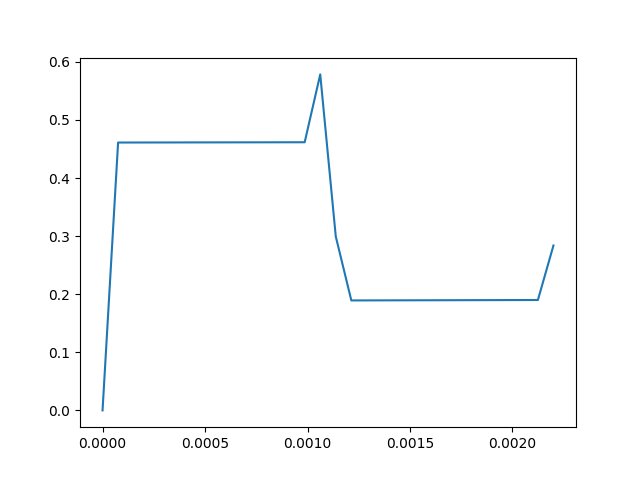

In [318]:
Omega = 5e3 * 2 * np.pi
t_pi = 1e-4
t_delay = 1e-3
detuning = 3e3 * 2 * np.pi

phase_pi = 0.0 * 2 * np.pi
phase_piov2 = 0.0 * 2 * np.pi
t_tot = t_delay * 2 + t_pi * 2

se = SpinEcho(Omega=Omega, t_pi=t_pi, t_delay=t_delay, detuning=detuning, phase_pi=phase_pi, phase_piov2=phase_piov2)

tlist = np.linspace(0, t_tot, 30)
output = se.solve(tlist)

fig, ax = plt.subplots()
ax.plot(tlist, output.expect[0])
#ax.plot(tlist, output.expect[1])
#ax.plot(tlist, output.expect[2])
#ax.plot(tlist, output.expect[3])
plt.show()

In [323]:
def coherence(t_delay):
    t_tot = t_delay * 2 + t_pi * 2
    tlist = np.linspace(0, t_tot, 1000)
    se = SpinEcho(Omega=Omega, t_pi=t_pi, t_delay=t_delay, detuning=detuning, phase_pi=0, phase_piov2=0)
    zero = se.solve(tlist).expect[0][-1]
    se = SpinEcho(Omega=Omega, t_pi=t_pi, t_delay=t_delay, detuning=detuning, phase_pi=0, phase_piov2=np.pi)
    full = se.solve(tlist).expect[0][-1]
    return full - zero

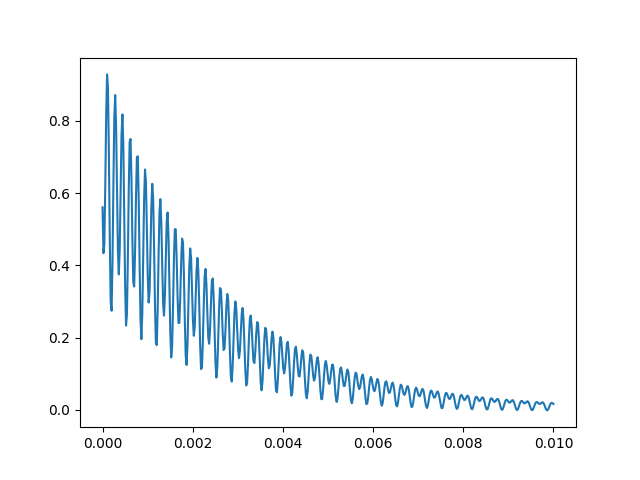

In [325]:
fig, ax = plt.subplots()
t_delays = np.linspace(0, 10e-3, 500)
coherences = [coherence(t_delay) for t_delay in t_delays]
ax.plot(t_delays, coherences)
plt.show()

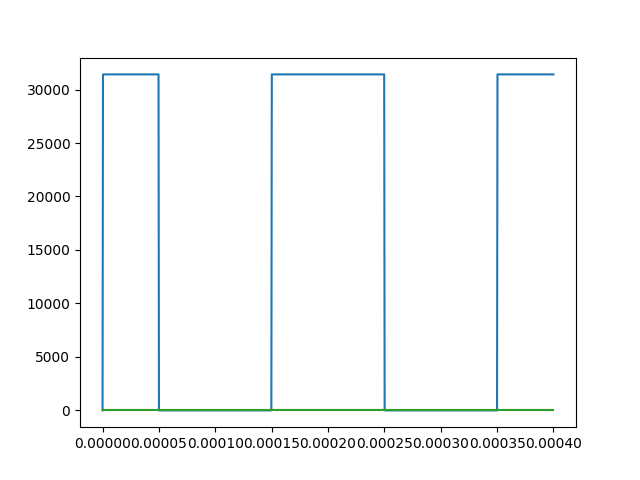

In [248]:
fig, ax = plt.subplots()
ax.plot(tlist, se.Omega_x(tlist, None))
ax.plot(tlist, se.Omega_y(tlist, None))
ax.plot(tlist, se.delta(tlist, None))
plt.show()